In [33]:
#https://www.jianshu.com/p/8263e9744fac
import pandas as pd;
import matplotlib.pyplot as plt;
import matplotlib;
import numpy as np;
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 240) # 设置打印宽度(**重要**)
#解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
print(matplotlib.matplotlib_fname())

/Users/walkingpotato/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc


In [2]:
#一、数据集
rawdata = pd.read_csv('cs-training.csv',index_col=[0]);
#print(rawdata.head());

In [3]:
column={
        'ID':'用户ID',
        'SeriousDlqin2yrs':'好坏客户',
        'RevolvingUtilizationOfUnsecuredLines':'可用额度比值',
        'age':'年龄',
        'NumberOfTime30-59DaysPastDueNotWorse':'逾期30-59天笔数',
        'DebtRatio':'负债率',
        'MonthlyIncome':'月收入',
        'NumberOfOpenCreditLinesAndLoans':'信贷数量',
        'NumberOfTimes90DaysLate':'逾期90天笔数',
        'NumberRealEstateLoansOrLines':'固定资产贷款量',
        'NumberOfTime60-89DaysPastDueNotWorse':'逾期60-89天笔数',
        'NumberOfDependents':'家属数量'
}
rawdata.rename(columns=column,inplace=True);
print(rawdata.head());

   好坏客户  可用额度比值  年龄  逾期30-59天笔数    负债率   月收入  信贷数量  逾期90天笔数  固定资产贷款量  逾期60-89天笔数  家属数量
1         1      0.766127    45                2  0.802982   9120.0        13             0               6                0       2.0
2         0      0.957151    40                0  0.121876   2600.0         4             0               0                0       1.0
3         0      0.658180    38                1  0.085113   3042.0         2             1               0                0       0.0
4         0      0.233810    30                0  0.036050   3300.0         5             0               0                0       0.0
5         0      0.907239    49                1  0.024926  63588.0         7             0               1                0       0.0


In [4]:
#查看数据维度
print(rawdata.shape);

(150000, 11)


In [5]:
#查看数据类型和缺失值
print(rawdata.info());
#“月收入”和“家属数量”有缺失

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
好坏客户          150000 non-null int64
可用额度比值        150000 non-null float64
年龄            150000 non-null int64
逾期30-59天笔数    150000 non-null int64
负债率           150000 non-null float64
月收入           120269 non-null float64
信贷数量          150000 non-null int64
逾期90天笔数       150000 non-null int64
固定资产贷款量       150000 non-null int64
逾期60-89天笔数    150000 non-null int64
家属数量          146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB
None


In [6]:
#查看标签分布
print(rawdata['好坏客户'].value_counts());

0    139974
1     10026
Name: 好坏客户, dtype: int64


In [7]:
#二、特征工程
#2.1去除重复值
rawdata.drop_duplicates(inplace=True);
rawdata.index=range(rawdata.shape[0]);
print(rawdata.shape);

(149391, 11)


In [8]:
#2.2缺失值处理
#查看缺失值情况
print(rawdata.isnull().mean());
#可以看到，“月收入”缺失达到近20%，“家属数量”缺失较少仅有2.6%的确实。

好坏客户           0.000000
可用额度比值       0.000000
年龄               0.000000
逾期30-59天笔数    0.000000
负债率             0.000000
月收入             0.195601
信贷数量           0.000000
逾期90天笔数       0.000000
固定资产贷款量     0.000000
逾期60-89天笔数    0.000000
家属数量           0.025624
dtype: float64


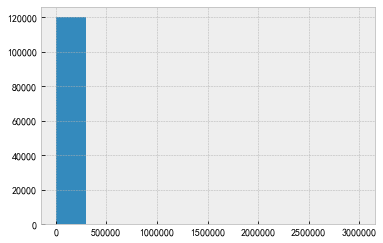

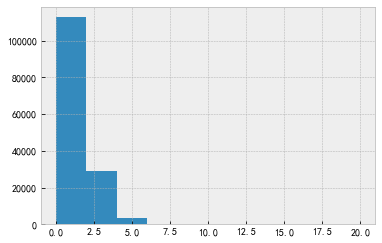

In [9]:
#查看缺失值分布形态
null_list=['月收入','家属数量'];
for col in null_list:
    plt.style.use('bmh');
    plt.hist(rawdata[col].dropna().values);
    plt.show();

In [10]:
#可以看到，数据呈现正偏态。由于“家属数量”缺失较少，我们直接用中位数填充。
rawdata['家属数量'].fillna(rawdata['家属数量'].median(),inplace=True)
#“月收入”这个特征对于征信来说非常重要，在这里采用随机森林填补法来填充，
#即将缺失的特征值作为预测值，将未缺失的“月收入”数据作为训练样本的标签。
#定义随机森林填补函数
def fill_missing_rf(X,y,to_fill):
    """
    使用随机森林填补一个特征的缺失值的函数
    参数：
    X：要填补的特征矩阵
    y：完整的，没有缺失值的标签
    to_fill：字符串，要填补的那一列的名称
    """
    #构建我们的新特征矩阵和新标签
    df = X.copy();
    fill = df.loc[:,to_fill];
    df = pd.concat([df.loc[:,df.columns != to_fill],pd.DataFrame(y)],axis=1);
    
    #找出我们的训练集和测试集
    Ytrain = fill[fill.notnull()];
    Ytest = fill[fill.isnull()];
    Xtrain = df.iloc[Ytrain.index,:];
    Xtest = df.iloc[Ytest.index,:];
    
    #用随机森林回归来填补缺失值
    from sklearn.ensemble import RandomForestRegressor as rfr;
    rfr = rfr(n_estimators=100);
    #训练合适的参数
    rfr = rfr.fit(Xtrain,Ytrain);
    #使用训练出来的参数的分类器，预测测试集的结果
    Ypredict = rfr.predict(Xtest);
    
    return Ypredict;

In [11]:
#用这个函数预测缺失的“月收入”部分，并替换缺失值。
X = rawdata.iloc[:,1:];#取除第一列之外的作为特征X
y = rawdata['好坏客户'];#取第一列作为标签，结果列

y_pred = fill_missing_rf(X,y,'月收入');
rawdata.loc[rawdata.loc[:,'月收入'].isnull(),'月收入'] = y_pred;

In [12]:
#异常值处理
#描述性统计
rawdata.describe([0.01,0.1,0.25,.5,.75,.9,.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
好坏客户,149391.0,0.066999,0.250021,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
可用额度比值,149391.0,6.071087,250.263672,0.0,0.0,0.003199,0.030132,0.154235,0.556494,0.978007,1.093922,50708.0
年龄,149391.0,52.306237,14.725962,0.0,24.0,33.000000,41.000000,52.000000,63.000000,72.000000,87.000000,109.0
逾期30-59天笔数,149391.0,0.393886,3.852953,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,98.0
负债率,149391.0,354.436740,2041.843455,0.0,0.0,0.034991,0.177441,0.368234,0.875279,1275.000000,4985.100000,329664.0
月收入,149391.0,5425.578974,13254.557747,0.0,0.0,0.170000,1800.000000,4424.000000,7416.000000,10800.000000,23205.000000,3008750.0
信贷数量,149391.0,8.480892,5.136515,0.0,0.0,3.000000,5.000000,8.000000,11.000000,15.000000,24.000000,58.0
逾期90天笔数,149391.0,0.238120,3.826165,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,98.0
固定资产贷款量,149391.0,1.022391,1.130196,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.000000,4.000000,54.0
逾期60-89天笔数,149391.0,0.212503,3.810523,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,98.0


[Text(0,0,'信贷数量'), Text(0,0,'固定资产贷款量')]

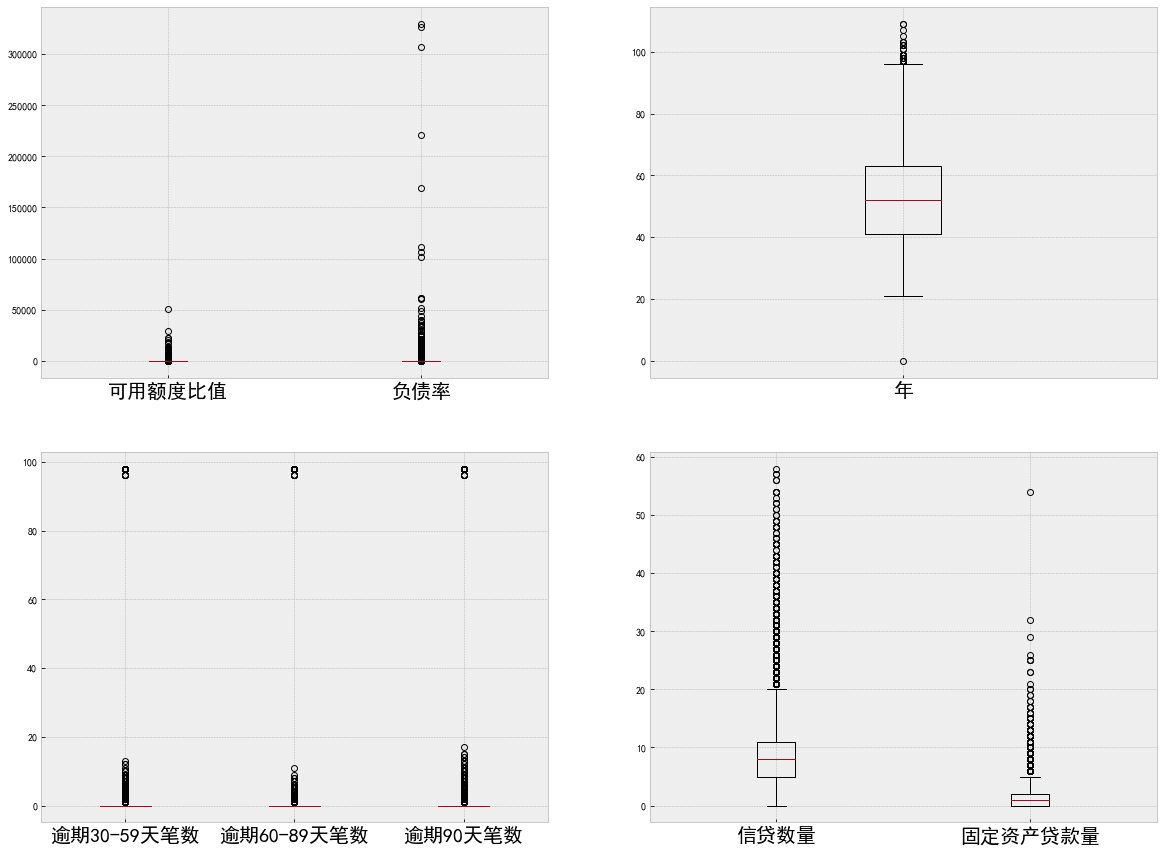

In [13]:
#如果这样看的不明显，完全可以再画出箱线图。
x1=rawdata['可用额度比值']
x2=rawdata['负债率']
x3=rawdata['年龄']
x4=rawdata['逾期30-59天笔数']
x5=rawdata['逾期60-89天笔数']
x6=rawdata['逾期90天笔数']
x7=rawdata['信贷数量']
x8=rawdata['固定资产贷款量']

fig=plt.figure(figsize=(20,15))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax3=fig.add_subplot(223)
ax4=fig.add_subplot(224)

ax1.boxplot([x1,x2])
ax1.set_xticklabels(["可用额度比值","负债率"], fontsize=20)

ax2.boxplot(x3)
ax2.set_xticklabels("年龄", fontsize=20)

ax3.boxplot([x4,x5,x6])
ax3.set_xticklabels(["逾期30-59天笔数","逾期60-89天笔数","逾期90天笔数"], fontsize=20)

ax4.boxplot([x7,x8])
ax4.set_xticklabels(["信贷数量","固定资产贷款量"], fontsize=20)

In [21]:
#我们可以先来看描述性统计，“年龄”的最小值居然是0，
#但是根据我们的常识，小于18岁是不能在银行办理信用卡或是贷款业务的。我们来看下小于18岁的有几行。
rawdata[rawdata['年龄']<18]
#会发现仅有“年龄”为0的这一行数据，很显然是异常值，将其删除。
rawdata=rawdata[rawdata['年龄']!=0]

In [27]:
#另外，通过箱线图，我们看到三个逾期天数指标（逾期30-59天、逾期60-80天，逾期90天）是存在比较严重的离群值的，这一点我们通过描述性统计也可以加以验证，这三个指标的99%分位数与max相差过大，存在异常。
#因为本案例定义逾期90天以上就算作坏客户，我们先查看一下这三个逾期指标超过90天的数据。
print(rawdata[rawdata['逾期30-59天笔数']>90].shape);
print(rawdata[rawdata['逾期60-89天笔数']>90].shape);
print(rawdata[rawdata['逾期90天笔数']>90].shape);
#可以看到维度均为(225, 11)，可以猜测这三个指标出现异常的情况发生在相同的行。 
print(rawdata[(rawdata['逾期90天笔数']>90) & (rawdata['逾期60-89天笔数']>90)
              & (rawdata['逾期30-59天笔数']>90)].shape);
#数据维度也是(225, 11)，果然验证了我们的猜想。将异常行删去。
rawdata=rawdata[rawdata.loc[:,'逾期30-59天笔数']<90]

(0, 11)
(0, 11)
(0, 11)
(0, 11)


In [31]:
#2.4处理样本不平衡
#我们在之前查看过标签分布情况，0:1=139974:10026，是存在严重的样本不平衡的。
#这是在金融风控中非常常见的，因为会存在严重违约的用户毕竟是少数。
#在这里我们采取SMOTE上采样的方法处理数据不平衡。需要导入另一个机器学习库imblearn。
import imblearn;
from imblearn.over_sampling import SMOTE;

smote = SMOTE(random_state=404)
X,y=smote.fit_sample(rawdata.iloc[:,1:],rawdata.iloc[:,0]);
pd.Series(y).value_counts()

1    139292
0    139292
dtype: int64

In [35]:
#我们将经过平衡后的数据合并为一个新的数据集
y = y.reshape(-1,1);
data = np.concatenate((y,X),axis=1);
data = pd.DataFrame(data,columns=rawdata.columns);
data.head()

,好坏客户,可用额度比值,年龄,逾期30-59天笔数,负债率,月收入,信贷数量,逾期90天笔数,固定资产贷款量,逾期60-89天笔数,家属数量
0,1.0,0.766127,45.0,2.0,0.802982,9120.0,13.0,0.0,6.0,0.0,2.0
1,0.0,0.957151,40.0,0.0,0.121876,2600.0,4.0,0.0,0.0,0.0,1.0
2,0.0,0.658180,38.0,1.0,0.085113,3042.0,2.0,1.0,0.0,0.0,0.0
3,0.0,0.233810,30.0,0.0,0.036050,3300.0,5.0,0.0,0.0,0.0,0.0
4,0.0,0.907239,49.0,1.0,0.024926,63588.0,7.0,0.0,1.0,0.0,0.0


In [47]:
#三、分箱
#常用的分箱方法主要有三种：等频分箱、等宽分箱、CART树分箱。
#我们选择最优的CART树分箱方法，将分箱的函数都写在一个cart_bins.py的类文件里，
#下面贴出了最重要的一个自动分箱函数。
def auto_bins(df,y,x,p=0.01,max_bin=20,plot=True):
    """
    参数
    df:传入需要进行分箱的数据集
    y:标签名
    x:进行分箱的特征名
    p:叶子包含观测数的最小占比(0<p<0.5)，默认为0.01
    max_bin:最大箱子数(大于2)，默认为20
    plot:是否画WOE图
    """
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import GridSearchCV
    import numpy as np
    import pandas as pd
    
    # 指明X和Y变量数据,排除NA值
    X = np.array(df[x][df[x].notna()]).reshape(-1,1)
    Y = df[y][df[x].notna()]
   
    # 调参,得到最合适的叶节点观测占比
    gini_impure = np.linspace(0,0.001,50)
    param_grid = {"min_impurity_decrease":gini_impure}
    Es = GridSearchCV(DecisionTreeClassifier(),param_grid,cv=5,iid=False)
    Es.fit(X,Y)
    
    # 使用最优参数构建树模型
    ES = DecisionTreeClassifier(min_impurity_decrease = 
                                Es.best_params_["min_impurity_decrease"],
                                max_leaf_nodes = max_bin,
                                min_samples_leaf = p)    
    ES.fit(X,Y)
    print(type(ES));
    print(type(x));
    
#     # 输出树结构
#     TS = tree_structure(ES,x)
    
    # 抽取测试节点的阈值
    TH = ES.tree_.threshold[ES.tree_.children_left != ES.tree_.children_right]
    # 计算最优分割点
    CP = np.append(TH,np.array([X.max(),X.min()]))
    CP.sort()
    
#     # 使用自定义分箱函数
#    smbin_cust = smbin_cu(df,y,x,cutpoints = CP,plot = plot)    
    
#     out_a = pd.Series({"Tree_structure":TS})
    
#     out = smbin_cust.append(out_a)

#     return(out)

In [48]:
#我们可以来看下几个特征分箱后的WOE图。
#可用额度比值
cut1 = auto_bins(data,'好坏客户','可用额度比值')

<class 'sklearn.tree.tree.DecisionTreeClassifier'>
<class 'str'>


In [50]:
#四、LR建模
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.3,random_state=1221)

In [ ]:
#五、生成评分卡
scorecard = smscale(glmodel,x_list,pdo=43,score=1150,odds=10)